**HW2 - Adil Mert Ergörün**

Loading the data, analyzing and creating a type vector

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
abalone_features = abalone.data.features
abalone_targets = abalone.data.targets

In [ ]:
# variable information
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

Quick data analysis:

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7            after being dried  grams             no  
8  +1.5 gives the age in years   None             no  

Creating type vector

In [3]:
# 1 if integer/real, 2 if categorical
feature_types = []

for i in abalone_features:
  if abalone_features[i].dtype == 'object':
    feature_types.append(2)
  else:
    feature_types.append(1)

print(feature_types)

[2, 1, 1, 1, 1, 1, 1, 1]


**Implementation of Desicion Tree Modeling Function**

In [4]:
def build_dt(X, y, attribute_types, options):
    return build_dt_rec(X, y, attribute_types, options, 0)

class Node:
  def __init__(self, feature_index=None, threshold=None, left=None, right=None, inf_gain=None, value=None):

      # For desicion nodes
      self.feature_index = feature_index
      self.threshold = threshold
      self.left = left
      self.right = right
      self.inf_gain = inf_gain

      # For leaf nodes
      self.value = value

def build_dt_rec(X, y, attribute_types, options, curr_depth):
    num_sample, num_feature = np.shape(X)

    if num_sample >= options['min_sample_split'] and curr_depth <= options['max_depth']:

        # This function gets the best split according to the entropy
        best_split = get_best_split(X, y, attribute_types)

        # If the split improves overall, we make the split
        if best_split and best_split['inf_gain'] > 0:
            left_subtree = build_dt_rec(best_split['X_left'], best_split['y_left'], attribute_types, options, curr_depth + 1)
            right_subtree = build_dt_rec(best_split['X_right'], best_split['y_right'], attribute_types, options, curr_depth + 1)
            return Node(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree, best_split['inf_gain'])

    leaf_value = get_leaf_value(y)
    return Node(value=leaf_value)

def get_best_split(X, y, attribute_types):
    num_sample, num_feature = np.shape(X)

    best_split = {}
    max_inf_gain = -float('inf')

    for feature_index in range(num_feature):
        feature_values = X[:, feature_index]
        possible_thresholds = np.unique(feature_values)

        for threshold in possible_thresholds:
            if attribute_types[feature_index] == 1:
                X_left, X_right, y_left, y_right = split_continuous(X, y, feature_index, threshold)
            else:
                X_left, X_right, y_left, y_right = split_categorical(X, y, feature_index, threshold)

            if len(y_left) > 0 and len(y_right) > 0:
                inf_gain = information_gain(y, y_left, y_right)
                if inf_gain > max_inf_gain:
                    best_split['feature_index'] = feature_index
                    best_split['threshold'] = threshold
                    best_split['X_left'] = X_left
                    best_split['X_right'] = X_right
                    best_split['y_left'] = y_left
                    best_split['y_right'] = y_right
                    best_split['inf_gain'] = inf_gain
                    max_inf_gain = inf_gain

    return best_split


def split_continuous(X, y, feature_index, threshold):
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold
    X_left = X[left_indices]
    X_right = X[right_indices]
    y_left = y[left_indices]
    y_right = y[right_indices]
    return X_left, X_right, y_left, y_right


def split_categorical(X, y, feature_index, threshold):
    left_indices = X[:, feature_index] == threshold
    right_indices = X[:, feature_index] != threshold
    X_left = X[left_indices]
    X_right = X[right_indices]
    y_left = y[left_indices]
    y_right = y[right_indices]
    return X_left, X_right, y_left, y_right


def information_gain(y, left, right):
    parent_entropy = entropy(y)
    left_entropy = entropy(left)
    right_entropy = entropy(right)
    child_entropy = (len(left) / len(y)) * left_entropy + (len(right) / len(y)) * right_entropy
    information_gain = parent_entropy - child_entropy
    return information_gain

def entropy(y):
    labels = np.unique(y)
    entropy = 0
    for cls in labels:
        p_cls = len(y[y == cls]) / len(y)
        entropy -= p_cls * np.log2(p_cls)
    return entropy

def get_leaf_value(y):
    unique, counts = np.unique(y, return_counts=True)
    index = np.argmax(counts)
    return unique[index]

# A basic function for printing the rules for the tree
def print_tree(tree, depth=0):
    indent = " " * depth

    if tree.value is not None:
        print(indent + "Leaf:", tree.value)
    else:
        print(indent + f"[X_{tree.feature_index} <= {tree.threshold} | InfoGain = {tree.inf_gain:.4f}]")
        print(indent + "--> Left:")
        print_tree(tree.left, depth + 4)
        print(indent + "--> Right:")
        print_tree(tree.right, depth + 4)

# A basic function for plotting the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

**Implementation of Desicion Tree Testing Function**

In [10]:
def predict_dt(dt, X, options=None):
    predictions = []
    for x in X:
        predictions.append(make_prediction(x, dt))
    return np.array(predictions)

def make_prediction(x, dt, options=None):
    if dt.value is not None:
        return dt.value

    if x[dt.feature_index] <= dt.threshold:
        return make_prediction(x, dt.left, options)
    else:
        return make_prediction(x, dt.right, options)

**Results of k-fold cross validation**

In [11]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

def k_fold_dt(X, y, k, options, prune=False):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accuracy_scores = []
    conf_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        options['curr_depth'] = 0

        dt = build_dt(X_train, y_train, feature_types, options)

        if prune is True:
            dt = post_prune(dt, X_train, y_train)

        y_pred = predict_dt(dt, X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        unique_labels = np.unique(np.concatenate((y_train, y_test)))
        conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

        conf_matrices.append(conf_matrix)

    return accuracy_scores, conf_matrices

Total Confusion Matrix Plot:


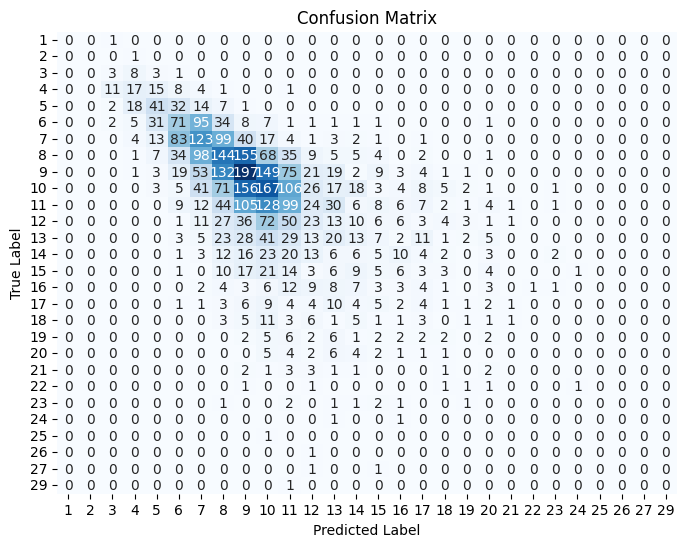

Average Accuracy: 0.22096667908202733


In [7]:
options = {
    'min_sample_split': 3,
    'max_depth': 10,
}

k = 5
accuracy_scores, conf_matrices = k_fold_dt(abalone_features.values, abalone_targets.values, k, options)

total_cm = np.sum(conf_matrices, axis=0)
print("Total Confusion Matrix Plot:")
plot_confusion_matrix(total_cm, np.unique(abalone_targets))

average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

Avg Accuracy: 0.22096667908202733

---

Confusion Matrix:

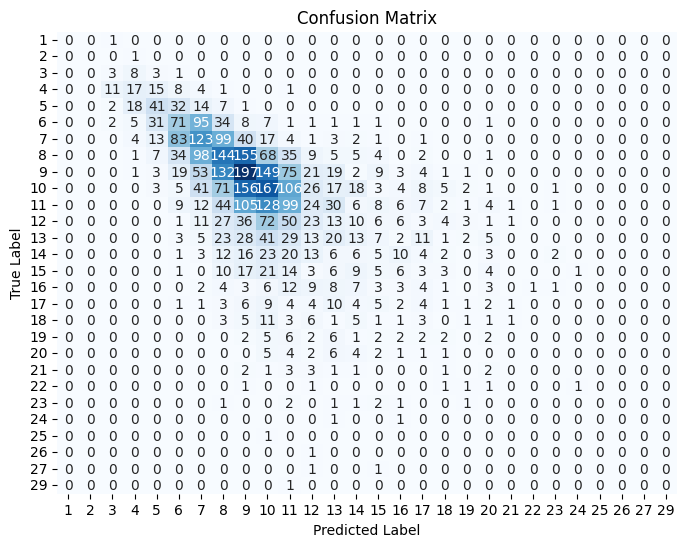

**Implementation of Decision Tree Testing Function with Pruning**

In [12]:
# In this function, we try to turn every node to a leaf and measure performance
# If we see an improvement, we keep it as a leaf

def post_prune(tree, X_val, y_val):
    def prune_node(node, X, y):
        if node.value is not None:
            return

        if len(X) == 0:
            return

        left_indices = X[:, node.feature_index] <= node.threshold
        right_indices = X[:, node.feature_index] > node.threshold

        # Recursively go down, prunning starts from the leafs
        prune_node(node.left, X[left_indices], y[left_indices])
        prune_node(node.right, X[right_indices], y[right_indices])

        y_pred_before = predict_dt(tree, X_val)
        accuracy_before = accuracy_score(y_val, y_pred_before)

        # Backup original node

        original_left = node.left
        original_right = node.right
        original_value = node.value

        # Replace with leaf

        node.left = None
        node.right = None
        node.value = get_leaf_value(y)

        y_pred_after = predict_dt(tree, X_val)
        accuracy_after = accuracy_score(y_val, y_pred_after)

        if accuracy_after < accuracy_before:
            node.left = original_left
            node.right = original_right
            node.value = original_value


    prune_node(tree, X_val, y_val)
    return tree


Results of k-fold cross validation

Total Confusion Matrix Plot:


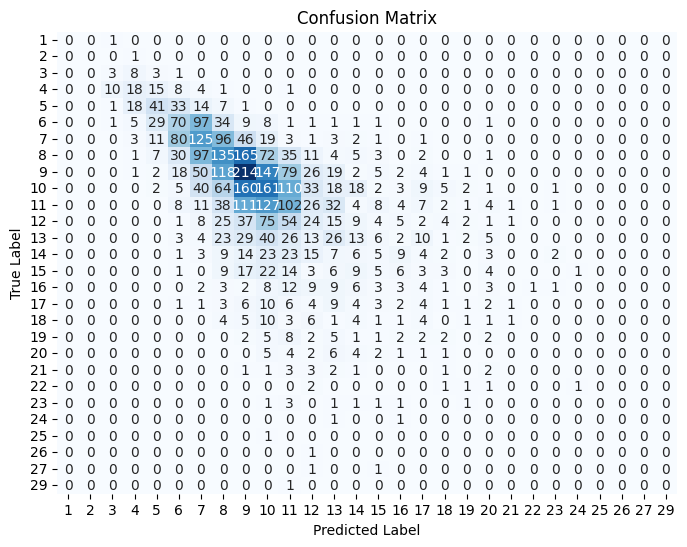

Average Accuracy: 0.22431911297023177


In [9]:
options = {
    'min_sample_split': 3,
    'max_depth': 10,
}

k = 5
accuracy_scores, conf_matrices = k_fold_dt(abalone_features.values, abalone_targets.values, k, options, prune=True)

total_cm = np.sum(conf_matrices, axis=0)
print("Total Confusion Matrix Plot:")
plot_confusion_matrix(total_cm, np.unique(abalone_targets))

average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.22431911297023177

---

Confusion Matrix:

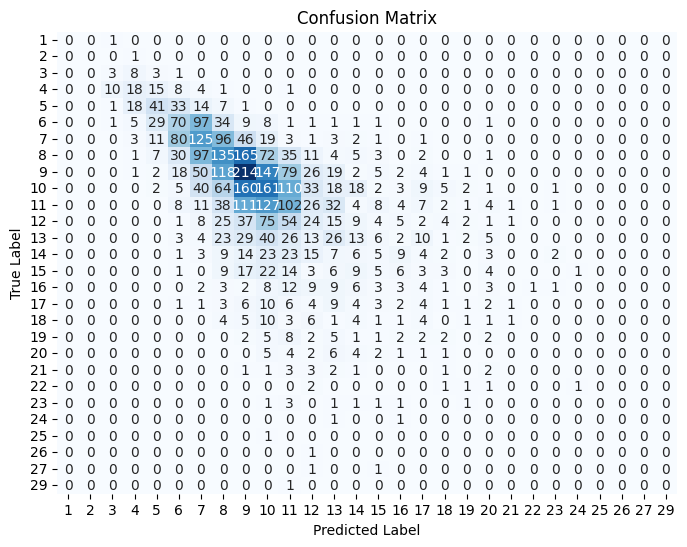

**Implementation of RDF**

In [ ]:
# Now for the random forest implementations

def build_rdf(X, y, attribute_types, N, options):
    trees = []
    for _ in range(N):
        X_sample, y_sample = bootstrap(X, y)
        tree = build_dt(X_sample, y_sample, attribute_types, options)
        trees.append(tree)

    return trees

def bootstrap(X, y):
    num_samples = X.shape[0]
    indices = np.random.choice(num_samples, size=num_samples, replace=True)
    return X[indices], y[indices]


In [ ]:
def predict_rdf(rdf, X, options=None):
    predictions = []
    for x in X:
        predictions.append(make_prediction_rdf(x, rdf))

    return predictions

def make_prediction_rdf(x, rdf):
    votes = [make_prediction(x, dt) for dt in rdf]
    return max(set(votes), key = votes.count)


Results of k-fold cross validation

Total Confusion Matrix Plot:


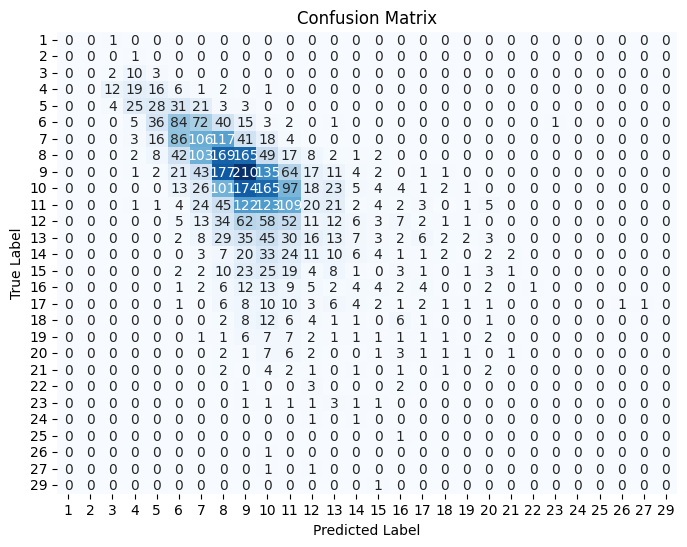

Average Accuracy: 0.2216872475145403


In [ ]:
def k_fold_rdf(X, y, k, options):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accuracy_scores = []
    conf_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        options['curr_depth'] = 0

        N=5
        rdf = build_rdf(X_train, y_train, feature_types, N, options)

        y_pred = predict_rdf(rdf, X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        unique_labels = np.unique(np.concatenate((y_train, y_test)))
        conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

        conf_matrices.append(conf_matrix)

    return accuracy_scores, conf_matrices

options = {
    'min_sample_split': 3,
    'max_depth': 10,
}

k = 5
accuracy_scores, conf_matrices = k_fold_rdf(abalone_features.values, abalone_targets.values, k, options)

total_cm = np.sum(conf_matrices, axis=0)
print("Total Confusion Matrix Plot:")
plot_confusion_matrix(total_cm, np.unique(abalone_targets))

average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.2216872475145403

---

Confusion Matrix:

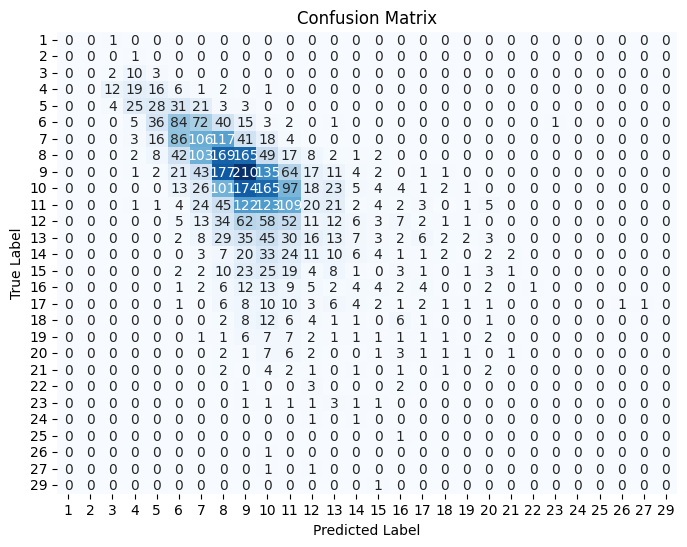